In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from dysts.base import DynSys
from scipy.integrate import solve_ivp
from tqdm import trange

from dystformer.augmentations import StandardizeTransform
from dystformer.chronos.pipeline import ChronosPipeline
from dystformer.patchtst.pipeline import PatchTSTPipeline

/stor/work/AMDG_Gilpin_Summer2024/miniconda3/envs/dystformer_jeff/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class KuramotoShivashinsky(DynSys):
    """Implements the 1+1D KS equation in fourier space"""

    def __init__(self, L: float, modes: int):
        super().__init__(metadata_path=None, dimension=2 * modes, parameters={})
        self.L = L
        self.modes = modes
        self.dimension = 2 * self.modes
        self.wave_nums = 2 * np.pi * np.arange(0, self.modes + 2) / self.L
        self.N = self.dimension + 2

        # precompute some quantities
        self.freq_domain = np.zeros(self.modes + 2, dtype=np.complex128)
        self.nonlinear_factor = -0.5 * 1j * self.wave_nums * self.N
        self.diffusion_ffts = self.wave_nums**2 - self.wave_nums**4

    def to_spatial(self, q: np.ndarray, N: int) -> np.ndarray:
        """Inverse FFT of the modes to get u(x) at a certain time

        :param q: array of flattened fourier coefficients (real and imag components), can have batch dimensions
        :param N: grid resolution in the spatial domain

        :returns: solution in the spatial domain
        """
        coeffs = np.zeros(q.shape[:-1] + (self.modes + 2,), dtype=complex)
        coeffs[..., 1:-1] = q[..., : self.modes] + 1j * q[..., self.modes :]
        return np.fft.irfft(coeffs, n=N)

    def rhs(self, t: float, X: np.ndarray) -> np.ndarray:
        self.freq_domain[1:-1] = X[: self.modes] + 1j * X[self.modes :]
        u = np.fft.irfft(self.freq_domain, n=self.N)
        pseudospectral_term = self.nonlinear_factor * np.fft.rfft(u * u)
        linear_term = self.diffusion_ffts * self.freq_domain

        # repackage components
        flow = (linear_term + pseudospectral_term)[1:-1]
        return np.concatenate([np.real(flow), np.imag(flow)])

In [3]:
ks = KuramotoShivashinsky(L=40, modes=60)

tfinal = 200
rng = np.random.default_rng(99)
ic = 0.1 * rng.normal(size=(ks.dimension,))
teval = np.linspace(0, tfinal, 4096)
sol = solve_ivp(
    ks.rhs, (0, tfinal), ic, method="DOP853", t_eval=teval, rtol=1e-8, atol=1e-8
)
ts, freq_traj = sol.t, sol.y.T
spatial_traj = ks.to_spatial(freq_traj, N=ks.dimension)

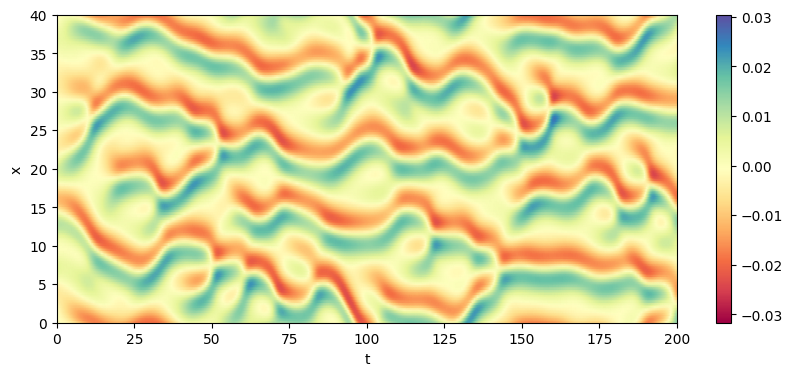

In [4]:
grid = np.linspace(0, ks.L, ks.dimension)
plt.figure(figsize=(10, 4))
plt.pcolormesh(ts, grid, spatial_traj.T, cmap="Spectral", shading="gouraud")
plt.colorbar()
plt.ylabel("x")
plt.xlabel("t")
plt.show()

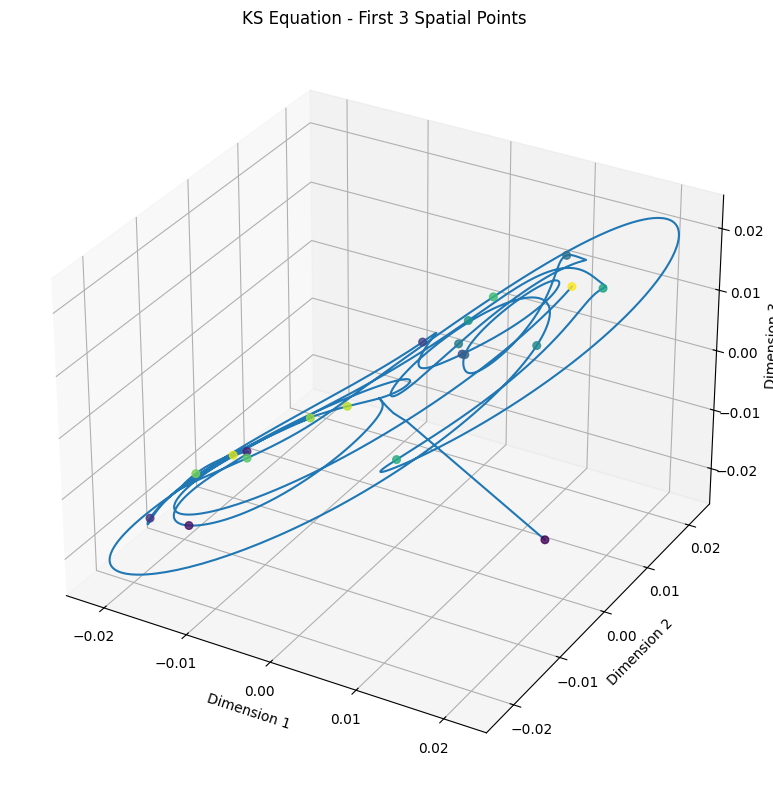

In [5]:
def plot_3d_trajectory(
    trajectory: np.ndarray,
    title: str = "3D Trajectory",
    figsize: tuple[int, int] = (12, 8),
) -> None:
    """Plot the first three dimensions of a trajectory in 3D space.

    Args:
        trajectory: Array of shape (T, D) where T is time steps and D is dimensions
        title: Plot title
        figsize: Figure size in inches (width, height)
    """
    if trajectory.shape[1] < 3:
        raise ValueError(
            f"Trajectory must have at least 3 dimensions, but has {trajectory.shape[1]}"
        )

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection="3d")

    # Plot the trajectory
    ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2])

    # Add scatter points to show direction
    n_points = min(20, len(trajectory))
    indices = np.linspace(0, len(trajectory) - 1, n_points, dtype=int)
    colors = plt.cm.viridis(np.linspace(0, 1, len(indices)))

    ax.scatter(
        trajectory[indices, 0],
        trajectory[indices, 1],
        trajectory[indices, 2],
        c=colors,
        s=30,
        alpha=0.8,
    )

    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")
    ax.set_title(title)

    plt.tight_layout()
    plt.show()


# Example: Plot the first 1000 time steps using the first 3 spatial points
plot_3d_trajectory(spatial_traj, title="KS Equation - First 3 Spatial Points")

In [6]:
pipeline = PatchTSTPipeline.from_pretrained(
    mode="predict",
    pretrain_path="/stor/work/AMDG_Gilpin_Summer2024/checkpoints/pft_chattn_noembed_pretrained_correct-0/checkpoint-final",
    device_map="cuda:0",
    torch_dtype=torch.float32,
)
pipeline

PatchTSTPipeline(mode='predict', model=PatchTSTForPrediction(
  (model): PatchTSTModel(
    (scaler): PatchTSTScaler(
      (scaler): PatchTSTStdScaler()
    )
    (patchifier): PatchTSTPatchify()
    (masking): Identity()
    (encoder): PatchTSTEncoder(
      (embedder): PatchTSTEmbedding(
        (input_embedding): Linear(in_features=16, out_features=512, bias=True)
      )
      (layers): ModuleList(
        (0-7): 8 x PatchTSTEncoderLayerWithRope(
          (temporal_self_attn): PatchTSTRopeAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (channel_self_attn): PatchTSTRopeAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, 

In [7]:
def forecast(
    pipeline,
    trajectory: np.ndarray,
    context_length: int,
    normalize: bool = True,
    transpose: bool = False,
    prediction_length: int | None = None,
    **kwargs,
) -> np.ndarray:
    context = trajectory[:context_length]
    if normalize:
        normalizer = StandardizeTransform()
        context = normalizer(context, axis=0)

    if prediction_length is None:
        prediction_length = trajectory.shape[0] - context_length

    if transpose:
        context = context.T

    predictions = (
        pipeline.predict(
            context=torch.tensor(context).float(),
            prediction_length=prediction_length,
            limit_prediction_length=False,
            **kwargs,
        )
        .squeeze()
        .cpu()
        .numpy()
    )
    full_trajectory = np.concatenate([context, predictions], axis=1 if transpose else 0)

    if transpose:
        full_trajectory = full_trajectory.T

    if normalize:
        return normalizer(
            full_trajectory,
            axis=0,
            context=trajectory[:context_length],
            denormalize=True,
        )

    return full_trajectory

In [8]:
def plot_forecast(
    ts: np.ndarray,
    grid: np.ndarray,
    trajectory: np.ndarray,
    predictions: np.ndarray,
    run_name: str = "",
    context_length: int = 0,
):
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(9, 9))
    vmin = min(trajectory.min(), predictions.min())
    vmax = max(trajectory.max(), predictions.max())
    vabs = max(abs(vmin), abs(vmax))

    for ax, data, label in zip(
        axes,
        [trajectory, predictions, predictions - trajectory],
        [
            "Ground Truth",
            f"Predictions ({run_name})",
            f"Prediction Error ({np.mean(np.abs(predictions - trajectory)):.2e}) ({run_name})",
        ],
    ):
        im = ax.pcolormesh(
            ts, grid, data.T, cmap="Spectral", shading="gouraud", vmin=-vabs, vmax=vabs
        )
        ax.set_ylabel("x")
        ax.set_title(label, fontweight="bold")
        fig.colorbar(im, ax=ax)
        # draw black vertical line at middle of plot (x axis middle)
        ax.axvline(ts[context_length], color="black", linewidth=1)
    axes[-1].set_xlabel("t")
    plt.tight_layout()

In [9]:
start_time = 1024
end_time = 2048
context_length = 512

In [10]:
# predict in frequency domain
predictions = forecast(
    pipeline,
    freq_traj[start_time:end_time],
    context_length,
    prediction_length=None,
    normalize=True,
    sliding_context=True,
)

# convert to spatial domain
spatial_predictions = ks.to_spatial(predictions, N=ks.dimension)

/stor/home/jl82436/dystformer/dystformer/patchtst/pipeline.py:217: UserWarning: We recommend keeping prediction length <= 128. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


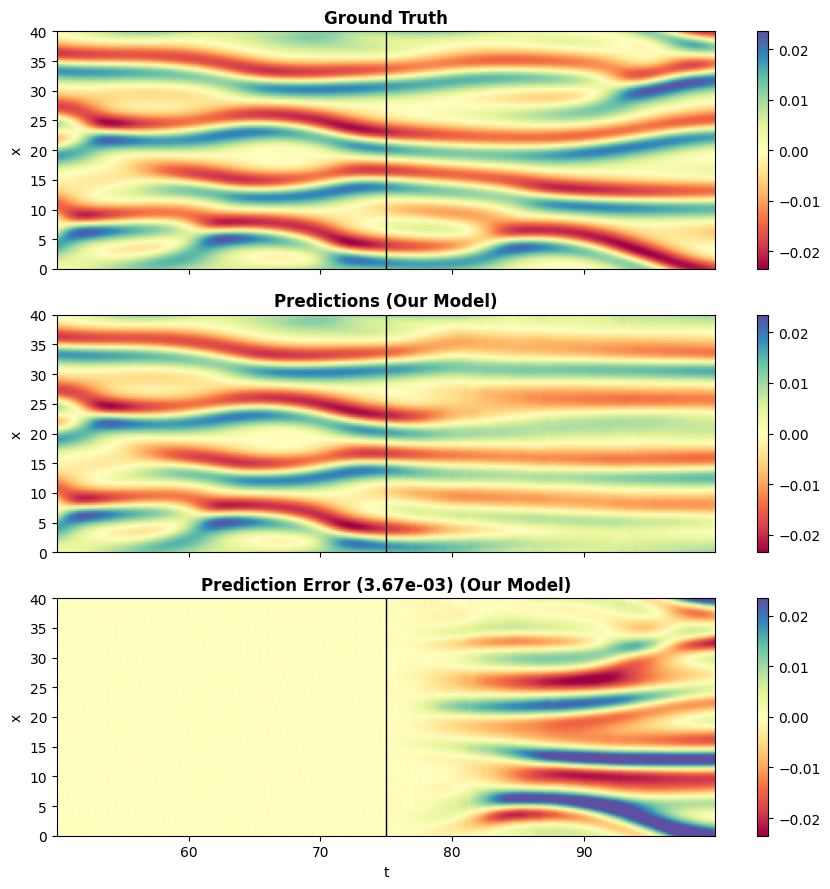

In [11]:
plot_forecast(
    ts[start_time:end_time],
    grid,
    spatial_traj[start_time:end_time],
    spatial_predictions,
    run_name="Our Model",
    context_length=context_length,
)

In [12]:
# predict in spatial domain
our_predictions = forecast(
    pipeline,
    spatial_traj[start_time:end_time],
    context_length,
    prediction_length=None,
    normalize=True,
    sliding_context=True,
)

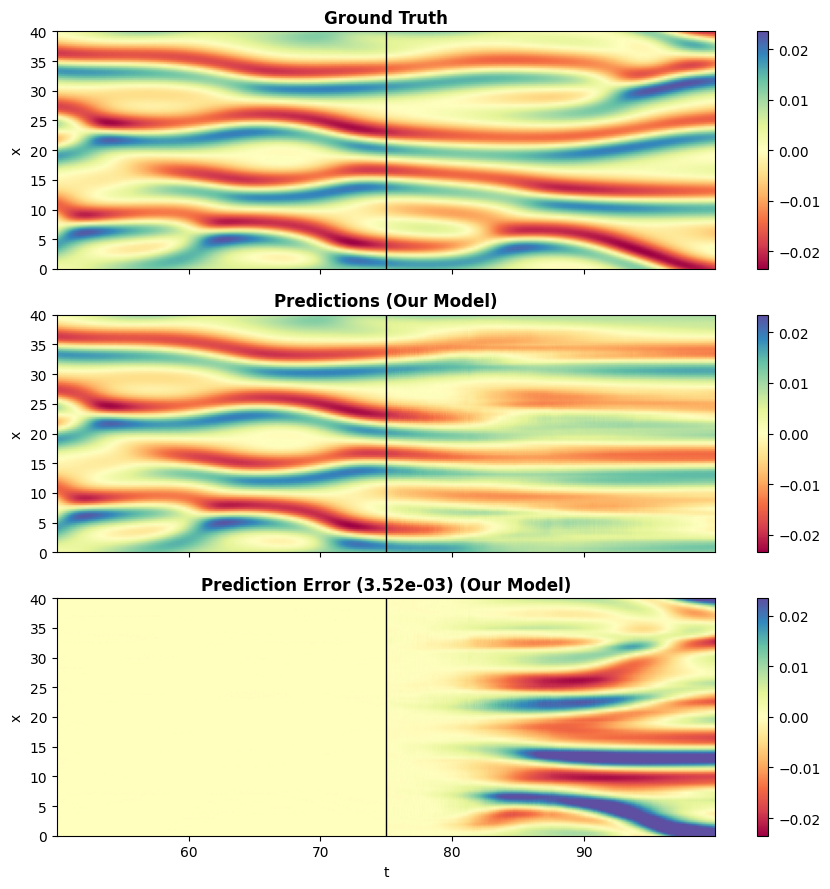

In [13]:
plot_forecast(
    ts[start_time:end_time],
    grid,
    spatial_traj[start_time:end_time],
    our_predictions,
    run_name="Our Model",
    context_length=context_length,
)

In [14]:
chronos = ChronosPipeline.from_pretrained(
    "/stor/work/AMDG_Gilpin_Summer2024/checkpoints/chronos_mini_ft-0/checkpoint-final",
    device_map="cuda:1",
    torch_dtype=torch.float32,
)
chronos

ChronosPipeline(tokenizer=<dystformer.chronos.tokenizer.MeanScaleUniformBins object at 0x7f93112eac10>, model=ChronosModel(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(4096, 384)
    (encoder): T5Stack(
      (embed_tokens): Embedding(4096, 384)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=384, out_features=512, bias=False)
                (k): Linear(in_features=384, out_features=512, bias=False)
                (v): Linear(in_features=384, out_features=512, bias=False)
                (o): Linear(in_features=512, out_features=384, bias=False)
                (relative_attention_bias): Embedding(32, 8)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
        

In [15]:
def forecast_chronos(
    pipeline,
    trajectory: np.ndarray,
    context_length: int,
    chunk_size: int,
) -> np.ndarray:
    subchannel_predictions = []
    for i in trange(0, trajectory.shape[1] // chunk_size):
        subpreds = forecast(
            pipeline,
            trajectory[:, i * chunk_size : (i + 1) * chunk_size],
            context_length,
            prediction_length=None,
            transpose=True,
            normalize=False,
            num_samples=1,
        )
        subchannel_predictions.append(subpreds)

    return np.concatenate(subchannel_predictions, axis=1)


In [159]:
# predict in frequency domain
chronos_predictions = forecast_chronos(
    chronos, freq_traj[start_time:end_time], context_length, chunk_size=ks.dimension
)

# convert to spatial domain
chronos_spatial_predictions = ks.to_spatial(chronos_predictions, N=ks.dimension)

  0%|          | 0/1 [00:00<?, ?it/s]/stor/home/jl82436/dystformer/dystformer/chronos/pipeline.py:157: UserWarning: We recommend keeping prediction length <= 128. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


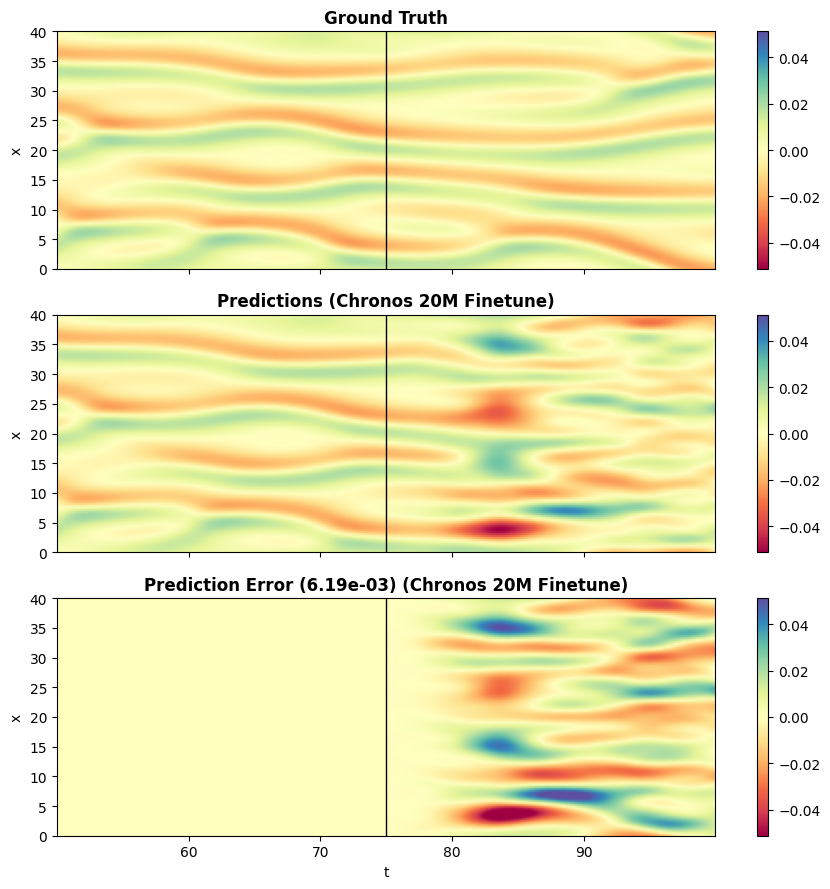

In [ ]:
plot_forecast(
    ts[start_time:end_time],
    grid,
    spatial_traj[start_time:end_time],
    chronos_spatial_predictions,
    run_name="Chronos 20M Finetune",
    context_length=context_length,
)

  0%|          | 0/1 [00:00<?, ?it/s]/stor/home/jl82436/dystformer/dystformer/chronos/pipeline.py:157: UserWarning: We recommend keeping prediction length <= 128. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)
100%|██████████| 1/1 [00:06<00:00,  6.45s/it]


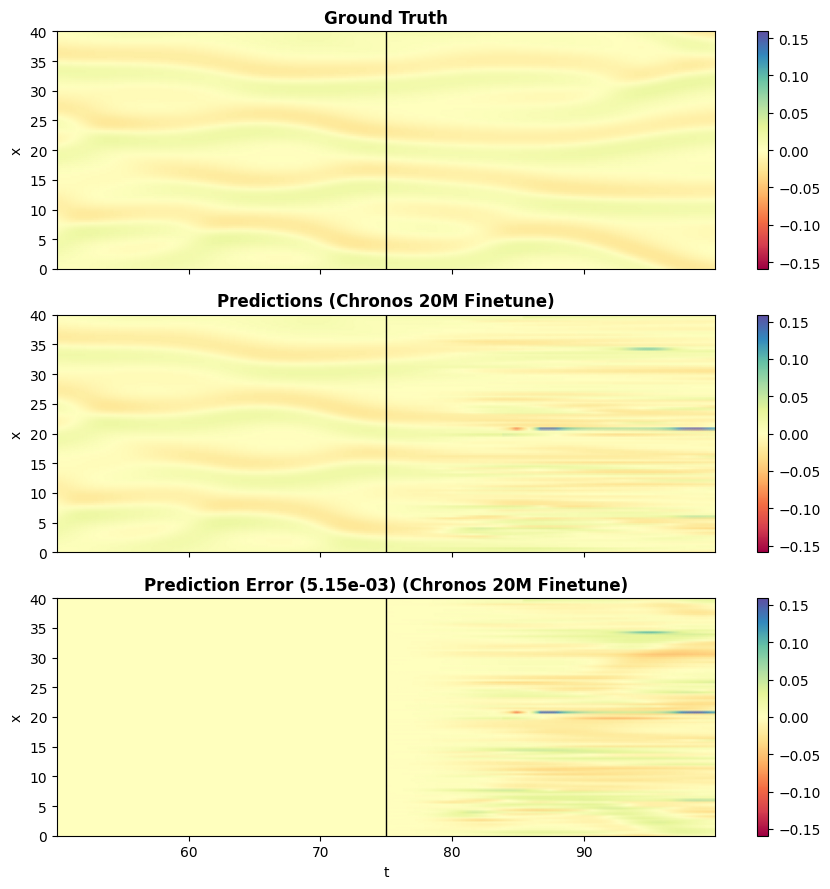

In [158]:
# spatial domain chronos prediction
chronos_spatial_predictions = forecast_chronos(
    chronos, spatial_traj[start_time:end_time], context_length, chunk_size=ks.dimension
)
plot_forecast(
    ts[start_time:end_time],
    grid,
    spatial_traj[start_time:end_time],
    chronos_spatial_predictions,
    run_name="Chronos 20M Finetune",
    context_length=context_length,
)

In [ ]:
chronos_zs = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-mini",
    device_map="cuda:1",
    torch_dtype=torch.float32,
)
chronos_zs

/stor/work/AMDG_Gilpin_Summer2024/miniconda3/envs/dystformer_jeff/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ChronosPipeline(tokenizer=<dystformer.chronos.tokenizer.MeanScaleUniformBins object at 0x7fa525f29610>, model=ChronosModel(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(4096, 384)
    (encoder): T5Stack(
      (embed_tokens): Embedding(4096, 384)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=384, out_features=512, bias=False)
                (k): Linear(in_features=384, out_features=512, bias=False)
                (v): Linear(in_features=384, out_features=512, bias=False)
                (o): Linear(in_features=512, out_features=384, bias=False)
                (relative_attention_bias): Embedding(32, 8)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
        

In [156]:
chronos_zs_predictions = forecast_chronos(
    chronos_zs, freq_traj[start_time:end_time], context_length, chunk_size=ks.dimension
)

# convert to spatial domain
chronos_zs_spatial_predictions = ks.to_spatial(chronos_zs_predictions, N=ks.dimension)

  0%|          | 0/1 [00:00<?, ?it/s]/stor/home/jl82436/dystformer/dystformer/chronos/pipeline.py:157: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)
100%|██████████| 1/1 [00:07<00:00,  7.70s/it]


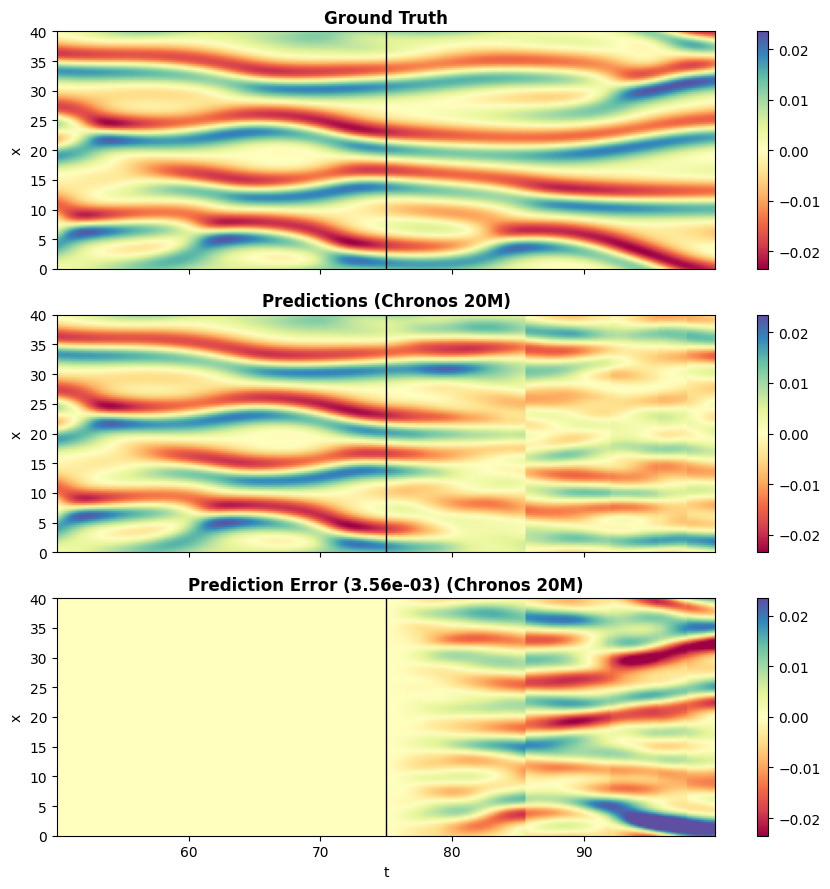

In [ ]:
plot_forecast(
    ts[start_time:end_time],
    grid,
    spatial_traj[start_time:end_time],
    chronos_zs_spatial_predictions,
    run_name="Chronos 20M",
    context_length=context_length,
)